**Continued from Part 2 Author Lifespan**

As we saw in Part 1, cross-posting seem to be exceptionally active between mid 2012 and mid 2013 (i.e. peak in the red curve). Generally speaking, posts in **r/MensRights** and **r/Feminism** should be about different topics (of course some may be related), because they are from two different subreddits after all. However, topics will evolve over time, and some factors (e.g. trolling) may cause posts in **r/MensRights** and **r/Feminism** to be limited to a narrow range of topics during some period. If so, posts within this period would likely have similar linguistic patterns (e.g. similar common words).

In this part, we'll compute some quantitative measures of dissmilarity/similarity of linguistic patterns between two corpora (lists of words from posts in **r/MensRights** and from posts in **r/Feminism**). Specifically, we define

* $D_{M}^{X}(I) = $ list of words of text from cross-posters posted in **r/MensRights**
* $D_{F}^{X}(I) = $ list of words of text from cross-posters posted in **r/Feminism**
* $D_{M}^{O}(I) = $ list of words of text from MensRights-only authors (must be posed in **r/MensRights**)
* $D_{F}^{O}(I) = $ list of words of text from Feminism-only authors (must be posted in **r/Feminism**)

Just as we elaborated in Part 1, $D_{M}^{X}(I)$, $D_{F}^{X}(I)$, $D_{M}^{O}(I)$ and $D_{F}^{O}(I)$ are defined as function of the time interval $I$, which means that the condition of being posted by *cross-posters*, *MensRights-only*, *Feminism-only* only applies to the given time interval $I$.

Word frequencies (e.g. from `["a", "a", "b"]` to `{"a": 2, "b": 1}` ) $C_{M}^{X}(I)$, $C_{F}^{X}(I)$, $C_{M}^{O}(I)$ and $C_{F}^{O}(I)$ can be derived from $D_{M}^{X}(I)$, $D_{F}^{X}(I)$, $D_{M}^{O}(I)$ and $D_{F}^{O}(I)$, respectively. And we will compute similarity measures (Cosine similarity and Jaccard similarity) $\rho(\cdot, \cdot)$ and dissimilarity measure (Jensen Shannon Divergence) $\delta(\cdot, \cdot)$between $C_{M}^{X}(I)$ and $C_{F}^{X}(I)$ (for cross-posters), and between $C_{M}^{O}(I)$ and $C_{F}^{O}(I)$ (for non-crossposters, namely, MensRights-only and Feminism-only).

-------------------
I'll illustrate the ETL steps for computing $D_{M}^{X}(I)$, $D_{F}^{X}(I)$, $D_{M}^{O}(I)$ and $D_{F}^{O}(I)$  with example.

First, connect to MongoDB

In [1]:
import datetime
from collections import Counter

import numpy as np
import pandas as pd
from pymongo import MongoClient
import pymongo

client = MongoClient("localhost", 27017)
db = client["reddit_polarization"]

In [2]:
db["MensRights"].drop_indexes()
db["Feminism"].drop_indexes()

### Preprocessing the text

Since the `body` field contains only the raw text, we need to run preprocessing steps on `body` field -- we need to remove tags, stem/lemmatize the words, remove stop words, and optionally, keeping only adjectives, nouns, and verbs, because they carry sentiment meanings. I wrote a module ***[preprocess.py](https://github.com/chao-ji/reddit/blob/master/preprocess.py)*** that contains functions for transforming text into list of tokens.

Here is a concrete example of how the raw text is transformed into clean list of tokens:

In [3]:
from preprocess import *

post = db["MensRights"].find_one()
print "Raw text:\n%r" % post["body"]
print 
print "List of words (nouns, adjectives and verbs only):"
print get_reddit_tokens(post["body"], njv_only=True)[:10]

Raw text:
u"That event actually happened when I was in sixth grade, way back in the day :)\n\nIm actually studying to be a teacher right now though, and I'd like to be as egalitarian as possible. But I might switch my major to something involving abnormal psych, where I'll have to be extremely non-judging."

List of words (nouns, adjectives and verbs only):
[u'event', u'happen', u'sixth', u'grade', u'way', u'day', u'study', u'teacher', u'right', u'like']


Now let's apply this function `get_reddit_tokens` on each post, and save the list of tokens in the field `tokens_njv`

In [4]:
for subreddit in ("MensRights", "Feminism"):
    collection = db[subreddit]

    ids = list(collection.find({}, {"_id": 1}))
    for one_id in ids:
        post= collection.find_one(one_id)
        body = post["body"]
        tokens = get_reddit_tokens(body, njv_only=True)
        collection.update_one(one_id, {"$set": {"tokens_njv": " ".join(tokens)}})

The tokens stored in the `tokens_njv` field contains only nouns, adjectives and verbs:

In [5]:
collection = db["MensRights"]
collection.find_one()

{u'_id': ObjectId('57c5ddd779a3030ce06585e6'),
 u'archived': True,
 u'author': u'sibqm_lmvm',
 u'author_flair_css_class': None,
 u'author_flair_text': None,
 u'body': u"That event actually happened when I was in sixth grade, way back in the day :)\n\nIm actually studying to be a teacher right now though, and I'd like to be as egalitarian as possible. But I might switch my major to something involving abnormal psych, where I'll have to be extremely non-judging.",
 u'controversiality': 0,
 u'created_utc': datetime.datetime(2012, 4, 30, 20, 0, 15),
 u'date': datetime.datetime(2012, 4, 30, 0, 0),
 u'distinguished': None,
 u'downs': 0,
 u'edited': False,
 u'gilded': 0,
 u'id': u'c4iiwis',
 u'link_id': u't3_t03pt',
 u'name': u't1_c4iiwis',
 u'parent_id': u't1_c4iiupq',
 u'removal_reason': nan,
 u'retrieved_on': 1428829641,
 u'score': 2,
 u'score_hidden': False,
 u'subreddit': u'MensRights',
 u'subreddit_id': u't5_2qhk3',
 u'tokens_njv': u'event happen sixth grade way day study teacher right 

### Compute the data for plotting the similarity/dissimilarity curves
#### Find posts with same 'date' and 'author'  
Remember that $D_{M}^{X}(I)$, $D_{F}^{X}(I)$, $D_{M}^{O}(I)$ and $D_{F}^{O}(I)$ are all the data we need to compute the similarity/dissimilarity. Suppose we have a document with the following fields:

`{"created_utc": created_utc0,
  "date": date0,
  "author": author0,
  "body": body0,
  "subreddit": "Feminism",
  "tokens_njv": tokens_njv0}`

we'd like to know if it is *cross-posted* -- in other words -- if there is at least one post by the *same author* `author0` in the *opposite* subreddit **r/MensRights** with timestamp between `date0 + datetime.timedelta(days=5)` and `date0 + datetime.timedelta(days=-5)`. If so, it will be included in $D_{F}^{X}$; else $D_{F}^{O}$

To test if a post a cross-posted, we can run the following function `is_crossposted` on each document in a collection. However, it is not the optimal way because an author may have multiple posts in the same day; in other words, we may have multiple documents with the same fields `date` and `author`. If `is_crossposted` returns `True` for one document, it must return `True` for another document that has the same `date` and `author` field.



```python
def is_crossposted(date0, author0, opposite_sr):
    dates = [date0 + datetime.timedelta(days=d) for d in range(-5, 5)]
    query = db[opposite_sr].find_one({"date": {"$in", dates}, "author": author0})
    return True if query else False
```        
        
We could optimize the query by grouping the documents by `(date, author)`, and aggregate the `tokens_njv` field. 

That is, we create a *Mapper*: 

`
def mapper(doc):
    emit(key=(doc["date"], doc["author"]), value=doc["tokens_njv"])
`

and a *Reducer*:

`
def reducer(key, values):
    tokens = []
    for value in values:
        tokens.extend(value)
    emit(key, tokens)
`

The reducer is implemented in the `agg_tokens` function. We'll create a dataframe on the data retrieved from MongoDB. Then we group the rows by `date` and `author`, and apply `agg_tokens` as the aggregation step.

In [6]:
def agg_tokens(df):
    counter = Counter()
    tokens_by_author_date = df["tokens_njv"].unique()
    for token_list in tokens_by_author_date:
        counter.update(filter(lambda token: len(token) > 0, token_list.split(" ")))
    return counter    

In [7]:
mensrights = list(db["MensRights"].find({}, {"date": 1, "author": 1, "tokens_njv": 1, "_id": 0}))
mensrights = pd.DataFrame(mensrights)
mensrights = mensrights.groupby(["date", "author"]).apply(agg_tokens)
mensrights.shape

(910294,)

In [8]:
mensrights[:5]

date        author    
2008-03-21  kanuk876      {u'claim': 1, u'harm': 2, u'unsubstantiated': ...
2008-03-24  WorcesterM    {u'deny': 1, u'woman': 2, u'acknowledge': 1, u...
2008-03-25  WorcesterM    {u'essay': 1, u'respond': 1, u'grade': 1, u're...
            linuxlass     {u'stanton': 1, u'term': 1, u'sure': 1, u'equa...
2008-03-26  Xiphorian     {u'case': 1, u'teacher-student': 1, u'actual':...
dtype: object

In [9]:
feminism = list(db["Feminism"].find({}, {"date": 1, "author": 1, "tokens_njv": 1, "_id": 0}))
feminism = pd.DataFrame(feminism)
feminism = feminism.groupby(["date", "author"]).apply(agg_tokens)
feminism.shape

(107881,)

In [10]:
feminism[:5]

date        author       
2009-02-06  stellar1                         {u'interesting': 1, u'notion': 1}
2009-04-13  Smight           {u'suicide': 2, u'many': 1, u'male': 1, u'fema...
2009-04-30  alexs            {u'appropriate': 1, u'thumbnail': 1, u'least': 1}
2009-05-11  darkreign        {u'woman': 1, u'technology': 1, u'men': 1, u'k...
2009-05-12  cyborg_selkie    {u'woman': 1, u'group': 1, u'figure': 1, u'thi...
dtype: object

In `mensrights` and `feminism` above, `{u'stanton': 1, u'term': 1, u'sure': 1, u'equa...` is the counter of tokens from posts by `linuxlass` within `2008-03-25`, and `{u'woman': 1, u'group': 1, u'figure': 1, u'thi...` is the counter of tokens from posts by `cyborg_selkie` within `2009-05-12`.

Note that we'll keep `mensrights` and `feminism` in memory as lookup table. However if it does not fit in memory, we can store it as a collection in mongodb and submit queries on the collection. 

-----------------

#### Identify crossposters, mensrights-only and feminism-only

We can repeat the process in Part 1. First define a helper function `authorlist_by_date` for data transformation:

1. Pull the data from MongoDB and store the data in dataframe
2. Group the rows in the dataframe by individual date (column date), and aggregate the rows in each group by merging the lists of authors.

So the resulting `men_author_groupby_day` and `fem_author_groupby_day` contains the list of authors who posted on each individual day.

In [11]:
def authorlist_by_date(subreddit):
    df = pd.DataFrame(list(db[subreddit].find({},
                                              {"author": 1, "date": 1})))
    
    author_groupby_day = df.groupby("date").apply(lambda x: x["author"].unique())
    return author_groupby_day

men_author_groupby_day = authorlist_by_date("MensRights")
fem_author_groupby_day = authorlist_by_date("Feminism")

In [12]:
men_author_groupby_day[:2]

date
2008-03-21      [kanuk876]
2008-03-24    [WorcesterM]
dtype: object

In [13]:
fem_author_groupby_day[:2]

date
2009-02-06    [stellar1]
2009-04-13      [Smight]
dtype: object

Now concatenate `men_author_groupby_day` and `fem_author_groupby_day` along axis=1.

In [14]:
author_groupby_day = pd.concat([men_author_groupby_day, fem_author_groupby_day],
                               axis=1, keys=["men_author", "fem_author"])
author_groupby_day = author_groupby_day.sort_index(axis=0)
author_groupby_day[-5:]

,men_author,fem_author
date,,
2016-07-27,"[Liv47, R_BirthStrike, WolfyCat, baserace, rww...","[WorstGringoNA, grantrob, i_have_a_semicolon, ..."
2016-07-28,"[juboboy, subzero_600, escobari, cld8, LenTheL...","[Soggy_Biscuit_, saccharind, DJWalnut, Hobbes_..."
2016-07-29,"[qemist, equiposeur, SigmundFloyd76, i_have_a_...","[HeavenlySun, ricnus, Hobbes_the_tiger, notano..."
2016-07-30,"[Real_nimr0d, elebrin, sillymod, JohnKimble111...","[Amvega, demmian, conuly, Hobbes_the_tiger, Ad..."
2016-07-31,"[Lethn, hhamama66, civilsaint, Foregen_Is_Life...","[polot38, HeavenlySun, weinbrandbabsi, raloicl..."


In [15]:
client.close()

Again, as in Part 1, we define helper function `group_author` to be applied on each row of dataframe `author_groupby_day`. It does the following:

1. For each date ( the `name` field of each `row`), find all the dates (`days`) within the interval (e.g. [date - 5 days, date + 5 days])
2. Merge the author lists from columns (men_author and fem_author) that fall within the interval, so the new lists of authors span the entire interval rather than only one day.
3. Compute and return the lists of authors **crossposter**, **MensRights-only**, and **Feminism-only**

In [16]:
radius = 5

def group_author(row, radius=5):
    """
    `row`: Series
    `row.name`: index value of the row (i.e. datetime)
    
    returns series containing three entries:
        `cp`: crossposters
        `men_only`: MensRights-only
        `fem_only`: Feminism-only
    """
    date = row.name
    days = [date + datetime.timedelta(days=d) for d in range(-radius, radius)]

    men_author = []
    fem_author = []
    for d in days:
        if d in author_groupby_day.index:
            if author_groupby_day.ix[d, "men_author"] is not np.nan:
                men_author.extend(list(author_groupby_day.ix[d, "men_author"]))
            if author_groupby_day.ix[d, "fem_author"] is not np.nan:
                fem_author.extend(list(author_groupby_day.ix[d, "fem_author"]))

    men_author = set(men_author)
    fem_author = set(fem_author)
    # crssposter would just be the intersection
    crossposter = men_author & fem_author
    men_only = men_author - crossposter
    fem_only = fem_author - crossposter

    return pd.Series([list(crossposter), list(men_only), list(fem_only)], index=["cp", "men_only", "fem_only"])

In [17]:
author_group = author_groupby_day.apply(lambda row: group_author(row, radius), axis=1)
author_group[-5:]

,cp,men_only,fem_only
date,,,
2016-07-27,"[Azure9861, i_have_a_semicolon, omegaphallic, ...","[Lost-In-Quaice, locks_are_paranoid, thesimen1...","[Moal, Jessicorama, snarky_llama, AnAccountFor..."
2016-07-28,"[Azure9861, omegaphallic, i_have_a_semicolon, ...","[Lost-In-Quaice, locks_are_paranoid, thesimen1...","[Moal, Jessicorama, snarky_llama, iMakeGreatDe..."
2016-07-29,"[Azure9861, omegaphallic, i_have_a_semicolon]","[Lost-In-Quaice, locks_are_paranoid, thesimen1...","[Moal, Jessicorama, snarky_llama, iMakeGreatDe..."
2016-07-30,"[Azure9861, omegaphallic, i_have_a_semicolon]","[Lost-In-Quaice, locks_are_paranoid, thesimen1...","[Jessicorama, snarky_llama, iMakeGreatDeals, M..."
2016-07-31,"[Azure9861, omegaphallic, i_have_a_semicolon]","[Lost-In-Quaice, locks_are_paranoid, thesimen1...","[Jessicorama, iMakeGreatDeals, sweet-potat0, B..."


`[Azure9861, i_have_a_semicolon, omegaphallic, ...` are those who posted in both **r/MensRights** and **r/Feminism** between `2016-07-22, 2016-07-31` (centered on `2016-07-27`); likewise for `[Lost-In-Quaice, locks_are_paranoid, thesimen1...` in column `men_only` and `[Moal, Jessicorama, snarky_llama, AnAccountFor...` in column `fem_only`

We'll further separate the author lists in `cp` as the follow: we create a duplicate copy of column `cp`, and rename them as `mensrights` and `feminism`. 

For example, we'll query the lookup tables that we have built in the beginning for tokens by authors in the list `[darkreign]` within the interval centered on `2009-05-07` with the matching subreddit:

In [18]:
crossposter = author_group[author_group["cp"].map(len) > 0][["cp"]]
crossposter["new"] = crossposter["cp"]
crossposter.columns = ["mensrights", "feminism"]
crossposter[:5]

,mensrights,feminism
date,,
2009-05-07,[darkreign],[darkreign]
2009-05-08,[darkreign],[darkreign]
2009-05-09,[darkreign],[darkreign]
2009-05-10,[darkreign],[darkreign]
2009-05-11,[darkreign],[darkreign]


Smilarly, we query the lookup tables for tokens by authors in `[Eever, Saydrah, ermine, IEatBabies, thomashau...` and `[stellar1]` within the interval centered on `2009-02-02` with the matching subreddit.

In [19]:
non_crossposter = author_group[(author_group["men_only"].map(len) > 0) &
                               (author_group["fem_only"].map(len) > 0)][["men_only", "fem_only"]]
non_crossposter.columns = ["mensrights", "feminism"]
non_crossposter[:5]

,mensrights,feminism
date,,
2009-02-02,"[Eever, Saydrah, ermine, IEatBabies, thomashau...",[stellar1]
2009-02-03,"[Eever, Saydrah, ermine, IEatBabies, thomashau...",[stellar1]
2009-02-04,"[Eever, Saydrah, ermine, IEatBabies, thomashau...",[stellar1]
2009-02-05,"[Eever, Saydrah, ermine, IEatBabies, thomashau...",[stellar1]
2009-02-06,"[Saydrah, steelfrog, IEatBabies, thomashauk, O...",[stellar1]


Define the helper function that implents the process

In [20]:
def group_counter(row, radius=5):
    date = row.name
    counters = []
    
    if date.month == 1 and date.day == 1:
        print date
    
    for subreddit in ("mensrights", "feminism"):
        dates = [date + datetime.timedelta(days=d) for d in range(-radius, radius)]
        authors = row[subreddit] 

        perdate = lookup[subreddit][dates]
        perdate.index = perdate.index.droplevel(0)
        perdate = perdate[authors]
        perdate = perdate[perdate.notnull()]
        
        counter = Counter()
        for c in perdate:
            counter.update(c)
        counters.append(counter)
    
    return pd.Series(counters, index=["from_mensrights", "from_feminism"])

In [21]:
lookup = {"mensrights": mensrights, "feminism": feminism}

Apply `group_counter` on `crossposter` to compute $C_{M}^{X}$ and $C_{F}^{X}$:

In [22]:
counter_crossposter = crossposter.apply(group_counter, axis=1)

2010-01-01 00:00:00
2011-01-01 00:00:00
2012-01-01 00:00:00
2013-01-01 00:00:00
2014-01-01 00:00:00
2015-01-01 00:00:00
2016-01-01 00:00:00


In [23]:
counter_crossposter[:5]

,from_mensrights,from_feminism
date,,
2009-05-07,"{u'late': 1, u'motherfucking': 1, u'pound': 1,...","{u'woman': 1, u'know': 1, u'whole': 1, u'men':..."
2009-05-08,"{u'late': 1, u'motherfucking': 1, u'pound': 1,...","{u'woman': 1, u'know': 1, u'whole': 1, u'men':..."
2009-05-09,"{u'late': 1, u'motherfucking': 1, u'pound': 1,...","{u'woman': 1, u'know': 1, u'whole': 1, u'men':..."
2009-05-10,"{u'late': 1, u'motherfucking': 1, u'pound': 1,...","{u'woman': 1, u'know': 1, u'whole': 1, u'men':..."
2009-05-11,"{u'late': 1, u'motherfucking': 1, u'pound': 1,...","{u'woman': 1, u'know': 1, u'whole': 1, u'men':..."


Apply `group_counter` on `non_crossposter` to compute $C_{M}^{O}$ and $C_{F}^{O}$

In [24]:
counter_non_crossposter = non_crossposter.apply(group_counter, axis=1)

2010-01-01 00:00:00
2011-01-01 00:00:00
2012-01-01 00:00:00
2013-01-01 00:00:00
2014-01-01 00:00:00
2015-01-01 00:00:00
2016-01-01 00:00:00


In [25]:
counter_non_crossposter[:5]

,from_mensrights,from_feminism
date,,
2009-02-02,"{u'limited': 3, u'perpetual-children': 1, u'no...","{u'interesting': 1, u'notion': 1}"
2009-02-03,"{u'limited': 3, u'perpetual-children': 1, u'dy...","{u'interesting': 1, u'notion': 1}"
2009-02-04,"{u'limited': 4, u'protestant': 1, u'suicidal':...","{u'interesting': 1, u'notion': 1}"
2009-02-05,"{u'limited': 5, u'protestant': 1, u'suicidal':...","{u'interesting': 1, u'notion': 1}"
2009-02-06,"{u'dynamic': 4, u'foul': 1, u'protest': 1, u'a...","{u'interesting': 1, u'notion': 1}"


Given the notation defined in the beginning and `counter_crossposter` and `counter_non_crossposter`, we have

* $C_{M}^{X}(I) =$ `{u'late': 1, u'motherfucking': 1, u'pound': 1,...`
* $C_{F}^{X}(I) =$ `{u'woman': 1, u'know': 1, u'whole': 1, u'men':...`

where $I =$ `[2009-05-02, 2009-05-11]` (centered on `2009-05-07`)

and
* $C_{M}^{O}(I) =$ `{u'limited': 3, u'perpetual-children': 1, u'no...`
* $C_{F}^{O}(I) =$ `{u'interesting': 1, u'notion': 1}`

where $I =$ `[2009-01-28, 2009-02-06]` (centered on `2009-02-02`)

-------------

### Compute similarity/dissimilarity metrics

Now that we're done with all the setups, we're ready to comput the similarity/dissimilarity metrics:

* Jaccard Similarity: ratio of number of words shared between the two counters over the size of their union
* Cosine Similarity: the two counters are unioned such that words that appear only in one counter get a pseudo count of 1
* Jensen Shannon Divergence: same as cosine similarity

Note for each of the following function `jaccard`, `cosine_sim`, `jsd`, we're cosidering only the top 10 percent most common words (i.e. `perc=0.1`)

In [26]:
del mensrights, feminism

In [27]:
from scipy.spatial.distance import cosine
from scipy.stats import entropy

def jaccard(row, perc=0.1):
    """Jaccard Similarity"""
    a = row["from_mensrights"]
    b = row["from_feminism"]

    len_a = len(a)
    len_b = len(b)

    if int(len_a * perc) >= 1 and int(len_b * perc) >= 1:
        a = a.most_common(int(len_a * perc))
        b = b.most_common(int(len_b * perc))
    else:
        a = a.most_common(len_a)
        b = b.most_common(len_b)

    a = set(dict(a).keys())
    b = set(dict(b).keys())

    return len(a & b) / float(len(a | b))

def cosine_sim(row, perc=0.1):
    """cosine similarity"""
    a = row["from_mensrights"]
    b = row["from_feminism"]

    len_a = len(a)
    len_b = len(b)

    if int(len_a * perc) >= 1 and int(len_b * perc) >= 1:
        a = a.most_common(int(len_a * perc))
        b = b.most_common(int(len_b * perc))
    else:
        a = a.most_common(int(len_a))
        b = b.most_common(int(len_b))

    a = set(dict(a).keys())
    b = set(dict(b).keys())
    c = a | b
    c = list(c)

    a = np.array(map(lambda x: float(row["from_mensrights"][x]) if x in row["from_mensrights"] else 0., c))
    b = np.array(map(lambda x: float(row["from_feminism"][x]) if x in row["from_feminism"] else 0., c))
    a = a + 1
    b = b + 1

    r = 1 - cosine(a, b)

    return r

def jsd(row, perc=0.1):
    """Jensen Shannon divergence"""

    a = row["from_mensrights"]
    b = row["from_feminism"]

    len_a = len(a)
    len_b = len(b)

    if int(len_a * perc) >= 1 and int(len_b * perc) >= 1:
        a = a.most_common(int(len_a * perc))
        b = b.most_common(int(len_b * perc))
    else:
        a = a.most_common(int(len_a))
        b = b.most_common(int(len_b))

    a = set(dict(a).keys())
    b = set(dict(b).keys())

    c = a | b
    c = list(c)
    a = np.array(map(lambda x: float(row["from_mensrights"][x]) if x in row["from_mensrights"] else 0., c))
    b = np.array(map(lambda x: float(row["from_feminism"][x]) if x in row["from_feminism"] else 0., c))
    a = a + 1
    b = b + 1

    avg = (a + b) / 2.
    return (entropy(a, avg, base=2.) + entropy(b, avg, base=2.)) / 2.


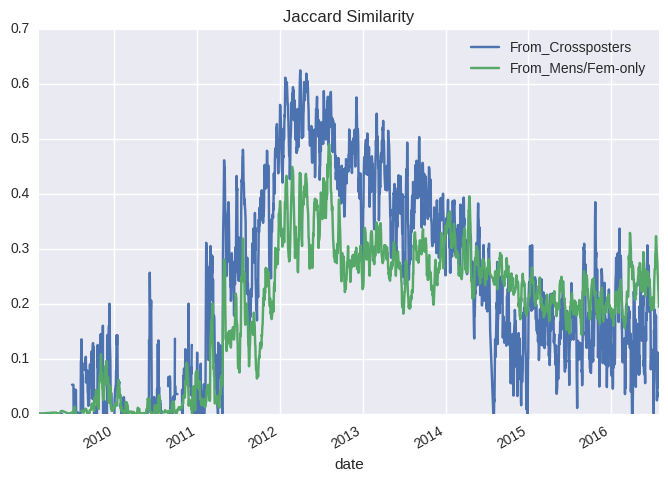

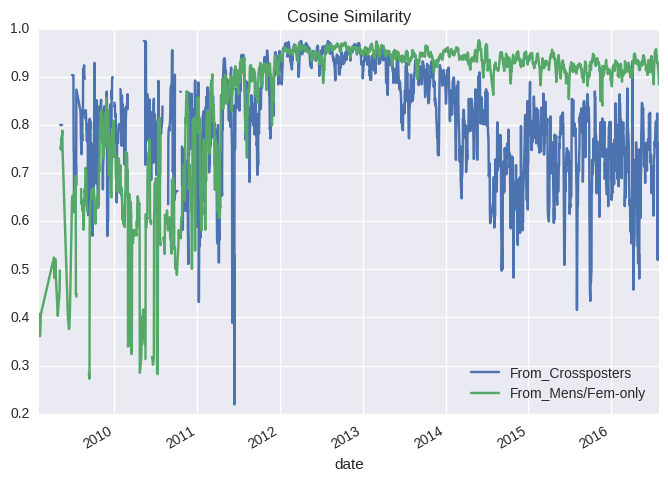

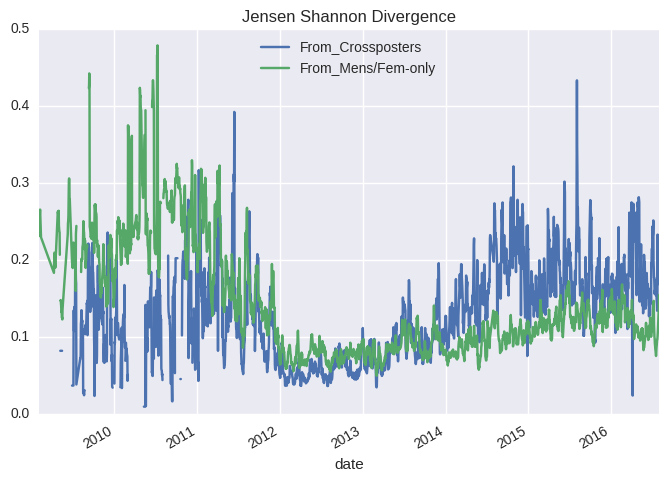

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

for func, name in zip((jaccard, cosine_sim, jsd),
                      ("Jaccard Similarity", "Cosine Similarity", "Jensen Shannon Divergence")):

    series_crossposter = counter_crossposter.apply(func, axis=1)    
    series_non_crossposter = counter_non_crossposter.apply(func, axis=1)

    df = pd.concat([series_crossposter, series_non_crossposter], axis=1,
                   keys=["From_Crossposters", "From_Mens/Fem-only"])
    df.plot()
    plt.title(name)
    plt.show()

As we can see, the word frequencies of posts from **r/MensRights** and **r/Feminism** seem to be more similar during mid 2012 and mid 2013 than anywhere else. And the timing of this event appears to coincide with the elevated cross-posting activity observed in Part 1.

### Wordcloud

Wordcloud (https://github.com/amueller/word_cloud) can be used to visualize the most frequent words from a corpus. We can apply wordcloud on the posts between mid 2012 and mid 2013 to have some intuitive idea what has been said. 

In [29]:
client = MongoClient("localhost", 27017)
db = client["reddit_polarization"]

db["MensRights"].create_index([("created_utc", pymongo.ASCENDING)])
db["Feminism"].create_index([("created_utc", pymongo.ASCENDING)])

u'created_utc_1'

In [30]:
low = datetime.datetime(year=2012, month=6, day=1)
high = datetime.datetime(year=2013, month=6, day=1)

counters = []
for subreddit in ("MensRights", "Feminism"):
    query = db[subreddit].find({"created_utc": {"$lte": high, "$gte": low}}, {"tokens_njv": 1})
    
    results = list(query)
    
    c = Counter()
    for doc in results:
        c.update(filter(lambda token: len(token) > 0, doc["tokens_njv"].split(" ")))
    counters.append(c)

In [31]:
mensrights_counter = counters[0]
mensrights_counter.most_common(10)

[(u'woman', 247949),
 (u'men', 199934),
 (u'get', 132788),
 (u'say', 130361),
 (u'people', 119032),
 (u'think', 111587),
 (u'make', 108445),
 (u'go', 86251),
 (u'feminist', 79889),
 (u'want', 72997)]

In [32]:
feminism_counter = counters[1]
feminism_counter.most_common(10)

[(u'woman', 44409),
 (u'men', 27532),
 (u'people', 24197),
 (u'think', 23205),
 (u'say', 23023),
 (u'make', 18773),
 (u'get', 17094),
 (u'rape', 13279),
 (u'feminist', 12522),
 (u'thing', 12489)]

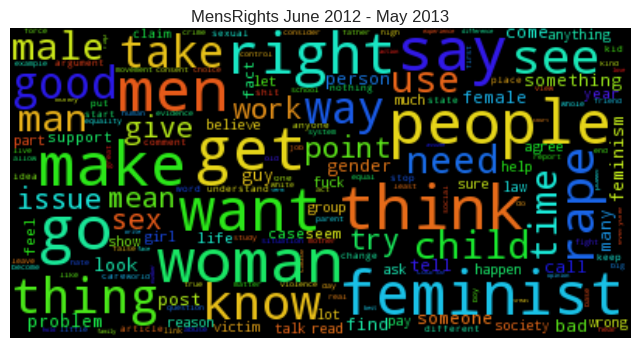

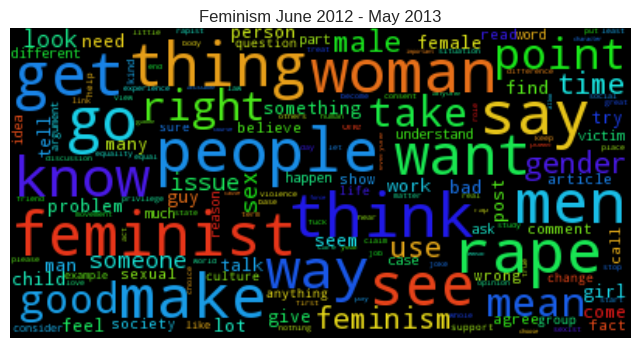

In [33]:
from wordcloud import WordCloud

wc_men = WordCloud(max_font_size=40).generate_from_frequencies((k, mensrights_counter[k]) for k in mensrights_counter.keys())
wc_fem = WordCloud(max_font_size=40).generate_from_frequencies((k, feminism_counter[k]) for k in feminism_counter.keys())

plt.imshow(wc_men)
plt.title("MensRights June 2012 - May 2013")
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(wc_fem)
plt.title("Feminism June 2012 - May 2013")
plt.xticks([])
plt.yticks([])
plt.show()